## Basic functions
[Github](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-08-06-03-Policy-Gradient-With-Gym-MiniGrid.ipynb)
Reference for this notebook.

In [ ]:
#installing the environment
from IPython.display import clear_output
!pip install gym
!pip install gym-minigrid
clear_output()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import HTML
from IPython import display
import torch
import torch.nn as nn
import glob
import io
import base64
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=2, suppress=True)

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def count_model_params(model):
    return sum(p.numel() for p in model.parameters())


def plot_learning_curve(rewards, success_rate, num_it):

    plt.plot(rewards, label='reward/eps')
    if success_rate:
        plt.plot(success_rate, label='success rate')
        plt.legend()
    else:
        plt.ylabel('return / eps')
    plt.ylim([0, 1])
    plt.xlim([0, num_it - 1])
    plt.xlabel('train iter')
    plt.grid('on')
    plt.show()

# Wrapper around dictionary that enables attribute access instead of the bracket syntax
# i.e. you can replace d['item'] with d.item
class ParamDict(dict):
    __setattr__ = dict.__setitem__
    def __getattr__(self, attr):
        # Take care that getattr() raises AttributeError, not KeyError.
        # Required e.g. for hasattr(), deepcopy and OrderedDict.
        try:
            return self.__getitem__(attr)
        except KeyError:
            raise AttributeError("Attribute %r not found" % attr)
    def __getstate__(self): return self
    def __setstate__(self, d): self = d

###To help agent training easily, we used `FlatObsWrapper` for flattening observation (in other words, 1D array)

In [ ]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
from gym_minigrid.wrappers import FullyObsWrapper

max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

###Visualisation of Agent



In [ ]:
from gym.wrappers.record_video import RecordVideo

def wrap_env(env):
    env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(FullyObsWrapper(gym.make(env_name,render_mode = 'rgb_array'))))

# This function plots videos of rollouts (episodes) of a given policy and environment
def log_policy_rollout(policy, env_name, pytorch_policy=False):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)

    # Initialize environment
    (observation,_) = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy:
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        (observation, reward, done, truncated, info) = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()

    show_video()

## Implement Rollout Buffer

There are couple of things to notice that,

- All information stored in RolloutBuffer should get the type of `torch.Tensor`
- In this case, returns will be used for minimizing the loss. So returns object should set the `requires_grad` to `True`
- It is inefficient to use all information to train the policy. To handle it, it requires something special sampling strategy. In this code, `BatchSample` is used.

In [ ]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutBuffer():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()

    def insert(self, step, done, action, log_prob, reward, obs):
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)

    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1, requires_grad=False)
        # Assuming Discrete Action Space
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)

    def compute_returns(self, gamma):
        # Compute Returns until the last finished episode
        self.last_done = (self.done == 1).nonzero().max()  if (self.done == 1).sum() > 0 else -1
        self.returns[self.last_done + 1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]

    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(
            SubsetRandomSampler(range(self.last_done)),
            batch_size,
            drop_last=True)
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

## Construct Policy Network

The policy is instantiated as a small neural network with simple fully-connected layers, the `ActorNetwork`. The role of policy is sort of strategy that generates the action. (Actually, it is just the probability to generate the action).
 And Of course, the important work through `ActorNetwork` is to update policy per each iteration. With pytorch, we need to define,

At first, Let's look gradient function used in policy gradient,

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] $$

Here, $\theta$ are the parameters of the policy network $\pi_{\theta}$ and $V_t(s)$ is the observed future discounted reward from state $s$ onwards which should be **maximized**. So we need the calculate the gradient of $\log \pi_{\theta}(a, s)$ and calculate its mean.

And Plus, there are some approaches to enhance the exploration. If we can consider the **entropy loss** to handle the overall loss, it takes diverse action. At that case gradient fuction will be,

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] + \nabla_{\theta}\mathcal{H}\big[\pi_\theta(a, s)\big]$$

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, state):
        x = self.fc(state)
        return x

And Below is the implementation of Policy. We select the Adam Optimizer

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate,
                 batch_size, policy_epochs, entropy_coef=0.001):
        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.actor(state)
        # To generate the probability of action, we assume its state has categorical distribution.
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

    def evaluate_actions(self, state, action):
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy

    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)

            for sample in data:
                actions_batch, returns_batch, obs_batch = sample

                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                # Compute the mean loss for the policy update using
                # action log-probabilities and policy returns
                policy_loss = -(log_probs_batch * returns_batch).mean()
                # Compute the mean entropy for the policy update
                entropy_loss = -entropy_batch.mean()

                loss = policy_loss + self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()

    @property
    def num_params(self):
        return count_model_params(self.actor)

In [ ]:
import time

def train(env, rollouts, policy, params, seed=12):
    # SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
    np.random.seed(seed)
    torch.manual_seed(seed)

    rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(params.num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        truncated = False
        (prev_obs,_) = env.reset(seed=seed)
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()

        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done or truncated :
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info:
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                (obs,_) = env.reset(seed=seed)
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs

            action, log_prob = policy.act(obs)
            (obs, reward, done, truncated, info) = env.step(action)
            #if reward ==0:
             # reward = -0.01


            rollouts.insert(step, torch.tensor(done, dtype=torch.float32), action, log_prob,
                            torch.tensor(reward, dtype=torch.float32),
                            prev_obs)

            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward

        # Use the rollout buffer's function to compute the returns for all stored rollout steps. (requires just 1 line)
        rollouts.compute_returns(params['discount'])

        rollout_done_time = time.time()


        # Call the policy's update function using the collected rollouts
        policy.update(rollouts)

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j,
                                                                                                avg_eps_reward.avg,
                                                                                                rollout_time.avg,
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate

###Traning

In [ ]:
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(FullyObsWrapper(nonwrapped_env))
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    rollouts = RolloutBuffer(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')

    policy = policy_class(obs_size, num_actions, **params.policy_params)
    return env, rollouts, policy

In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 150,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-5x5-v0',  # we are using a tiny environment here for testing
)

In [ ]:
env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


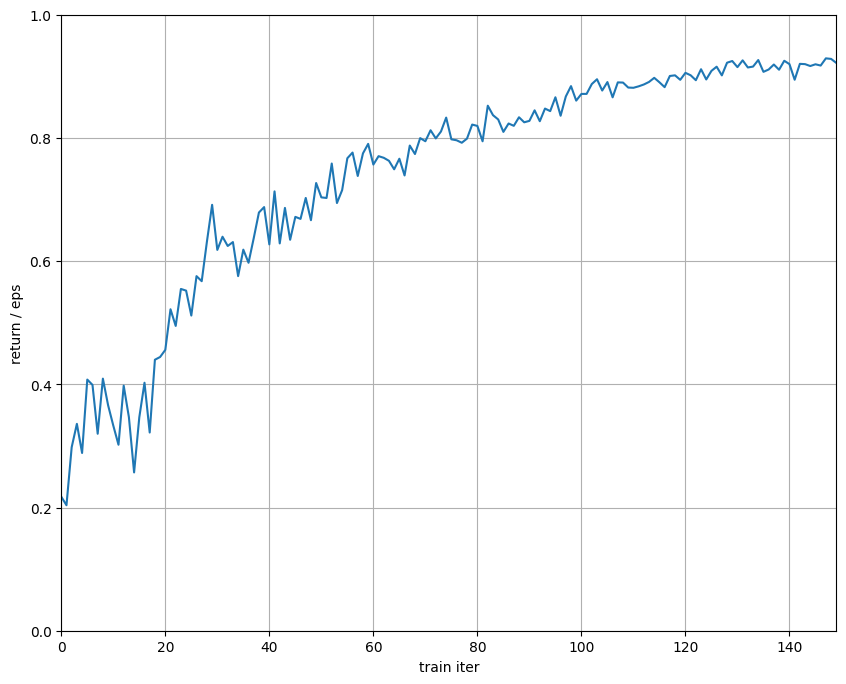

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Total reward: 0.9279999999999999
Total length: 8


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Total reward: 0.955
Total length: 5


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Total reward: 0.955
Total length: 5


In [ ]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)